<a href="https://colab.research.google.com/github/Lutris98/PersonalProject/blob/main/3.Prediction/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [145]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout #Dropout은 필수
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [146]:
url='https://finance.naver.com/item/sise_day.nhn?code=035720'
headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'}
kresponse=requests.get(url, headers = headers).text
html=BeautifulSoup(kresponse,'lxml') 
pgrr=html.find('td',class_='pgRR')
s=str(pgrr.a['href']).split('=')
last_page=s[-1] 
k_df=pd.DataFrame()
for page in range(1, int(last_page)+1): 
  page_url='{0}&page={1}'.format(url,page) 
  kresponse=requests.get(page_url, headers = headers).text
  k_df=k_df.append(pd.read_html(kresponse,header=0)[0]) 
k_df=k_df.dropna()

##1)Basic Feature selection

In [147]:
k_df=k_df.rename(columns={'날짜':'Date','시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'}) 
k_df.index=pd.to_datetime(k_df['Date']) 
k_df=k_df[['Open','High','Low','Close','Volume']] #2개 이상으로 새 dataframe 만들때 
k_df.sort_index(inplace=True)
k_df=k_df.iloc[-501:-1] #loc만 마지막 포함 

#2.Preprocessing

##1)Scaling

In [148]:
scaled_df=MinMaxScaler().fit_transform(k_df) #list반환 주의!
scaled_df=pd.DataFrame(scaled_df,columns=['Open','High','Low','Close','Volume'])
target_df=scaled_df['Close'] #target도 scale ver

#3.Modeling

In [149]:
x=scaled_df.values.tolist() #텐서플로의 신기함(dataframe에서 ndarray에서 list로)
y=target_df.values.tolist()
xdata=[]
ydata=[]
window=10 #10일씩 묶어서 훨씬 늘림
for i in range(len(y)-window):
  x_=x[i:i+window] #9개씩
  y_=y[i+window] #종가는 하나씩
  xdata.append(x_)
  ydata.append(y_)
print(x_,"->",y_) #맨마지막 

[[0.8884481903817552, 0.9106487148102814, 0.8996739403059945, 0.8917322834645669, 0.15515180163692838], [0.9033217649975211, 0.8910648714810282, 0.8595435164283923, 0.8499015748031495, 0.18428420681824925], [0.8438274665344572, 0.8482252141982863, 0.8319538500125406, 0.8511318897637794, 0.15285097012730509], [0.8785324739712443, 0.8824969400244799, 0.8783546526210183, 0.8609744094488188, 0.10428497697105582], [0.8797719385225582, 0.8947368421052632, 0.8871331828442438, 0.9015748031496063, 0.12298711624729686], [0.910758552305404, 0.8971848225214197, 0.8921494858289439, 0.8831200787401574, 0.07558735448385126], [0.895884977689638, 0.8922888616891064, 0.8883872585904188, 0.8843503937007873, 0.05428614595299436], [0.8909271194843829, 0.8947368421052632, 0.8946576373212941, 0.889271653543307, 0.07544550491080472], [0.9033217649975211, 0.9082007343941249, 0.9009280160521694, 0.8991141732283463, 0.1185603093499498], [0.9181953396132871, 0.9645042839657282, 0.9347880611988965, 0.9692421259842

In [150]:
test_size=int(len(ydata)*0.3) #공부를 좀 더 해서 순서대로 하는게 맞는 건지등 ROCV는 뭔지등 공부(아직 멀었다!)
X_train=np.array(xdata[0:len(xdata)-test_size+1]) #개수 맞추기
X_test=np.array(xdata[len(xdata)-test_size:len(xdata)])
y_train=np.array(ydata[0:len(ydata)-test_size+1])
y_test=np.array(ydata[len(ydata)-test_size:len(ydata)])

In [151]:
model=Sequential()
model.add(LSTM(units=10,activation='relu',input_shape=(window,5),return_sequences=True)) #마지막에 과정 표현여부 선택
model.add(Dropout(0.1))
model.add(LSTM(units=10,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary() #layer구조확인

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 10)            640       
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer='adam',loss='mean_squared_error') #딥러닝은 compile후 fit_predict
model.fit(X_train,y_train,epochs=60,batch_size=30) #같은 데이터로 몇번 반복/몇건씩 입력할건지
pred=model.predict(X_test)

Epoch 1/60
12/12 [==============================] - 2s 7ms/step - loss: 0.0272
Epoch 2/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0116
Epoch 3/60
12/12 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 4/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 5/60
12/12 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 6/60
12/12 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 7/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 8/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 9/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 10/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0016
Epoch 11/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 12/60
12/12 [==============================] - 0s 8ms/step - loss: 0.0026
Epoch 13/60
12/12 [==============================

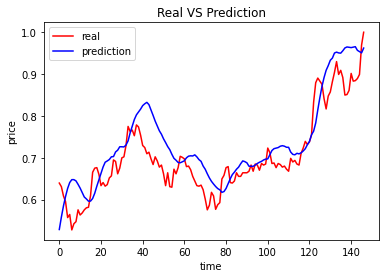

In [153]:
plt.plot(y_test,color='red',label='real')
plt.plot(pred,color='blue',label='prediction')
plt.title('Real VS Prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [154]:
print("내일 카카오톡 주가는 {0}원 : ".format(pred[-1]*k_df.Close.iloc[-1]/scaled_df.Close.iloc[-1])) #다시 scale돌려놓기

Tomorrow's price :  [482995.62]
